# Remaining Useful Life Prediction Using Convolution Networks

In this notebook, we develop a model for the remaining useful life (RUL) prediction. The model architecture is based on [1], but significantly modified.

### Data
We use **NASA Turbofan Engine** dataset (see **datasets.md** for details).

### References
1. Xiang Li, Qian Ding, Jian-Qiao Sun, Remaining useful life estimation in prognostics using deep convolution neural networks, 2018

In [21]:
import os
import math
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.model_selection import train_test_split
from tabulate import tabulate
import platform

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
warnings.simplefilter("ignore")

print(f'Python {platform.python_version()} | TF {tf.__version__} | Keras {tf.keras.__version__}')

Python 3.10.2 | TF 2.8.0 | Keras 2.8.0


Number of informative sensors: 14


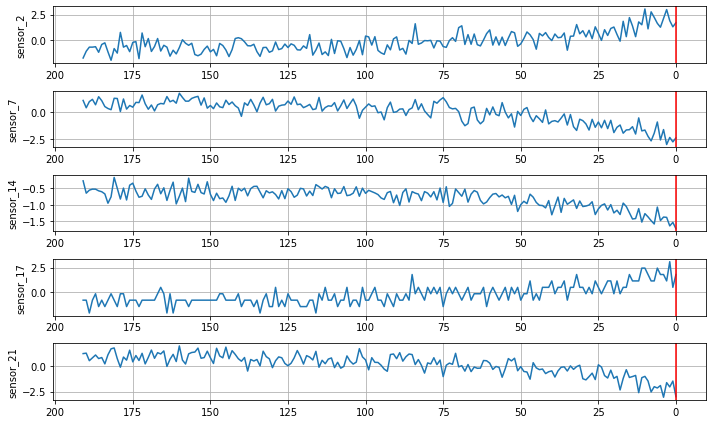

In [23]:
data_basedir = '../../turbofan-engine-degradation/'

valid_sensor_ids = [2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21]
valid_sensor_cols = [f'sensor_{s}' for s in valid_sensor_ids]

def load_data(features_filename, max_rul):
    col_name = ['engine_id', 'time', 'op_setting_1', 'op_setting_2', 'op_setting_3']
    col_name = col_name + [f'sensor_{s}' for s in range(1, 22)]
    df = pd.read_csv(data_basedir + features_filename, header=None, names=col_name, delim_whitespace=True, index_col=0)
    
    #
    # Drop non-informative sensors
    #
    for s in range(1, 22):
        if s not in valid_sensor_ids:
            df = df.drop(columns=f'sensor_{s}')
    
    #
    # Column-wise normalization
    #
    df.iloc[:, 2:] = df.iloc[:, 2:].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
    
    #
    # Calculate RUL based on the sequence length
    #
    df = df.join(df.groupby(['engine_id'])['time'].max(), on='engine_id', rsuffix='_max')
    df['rul'] = (df['time_max'] - df['time']).clip(upper = max_rul)
    
    return df

def get_engine(df, engine_id):
    return df[df.index.isin([engine_id])]

MAX_RUL = 150
df = load_data('train_FD001.txt', MAX_RUL)

#
# Plot several sensor series for one engine 
#
engine_id = 1
fig, ax = plt.subplots(5, 1, figsize=(10, 6))
for i, s in enumerate([2, 7, 14, 17, 21]):
    x = get_engine(df, engine_id)['time_max'] - get_engine(df, engine_id)['time']
    ax[i].plot(x, get_engine(df, engine_id)[f'sensor_{s}'])
    ax[i].invert_xaxis()
    ax[i].grid(True)
    ax[i].set_ylabel(f'sensor_{s}')
    ax[i].axvline(x=0, color='red')
plt.tight_layout()
print(f'Number of informative sensors: {len(valid_sensor_ids)}')

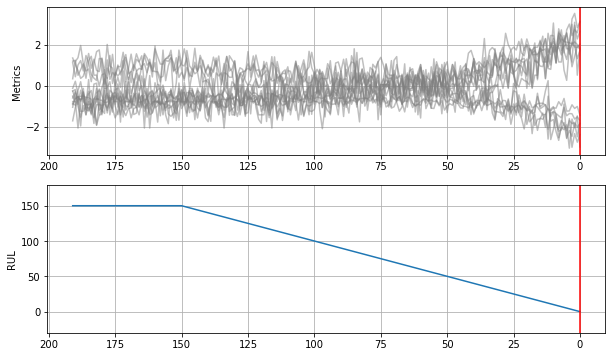

In [30]:
#
# Visualize the trainig data for one enigne
#
engine_id = 1
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
x = (get_engine(df, engine_id)['time_max'] - get_engine(df, engine_id)['time']).values
ax[0].plot(x, get_engine(df, engine_id)[valid_sensor_cols].values, color='gray', alpha=0.5)
ax[0].set_ylabel('Metrics')
ax[1].plot(x, get_engine(df, engine_id)['rul'])
ax[1].set_ylabel('RUL')
ax[1].set_ylim(-0.2*MAX_RUL, 1.2*MAX_RUL)

for i in range(2):
    ax[i].grid(True)
    ax[i].axvline(x=0, color='red')
    ax[i].invert_xaxis()
plt.show()

In [11]:
#
# Preparing the training data
#
x0 = df[['time'] + valid_sensor_cols]
y0 = df['rul']

n_cols = x0.shape[1]
n_engines = x0.index.nunique()
window_size = 30
    
def input_tensors(x, y, engine_ids):
    x_sequences = []
    y_sequences = []
    for engine_id in engine_ids:
        x_seq = get_engine(x, engine_id)
        y_seq = get_engine(y, engine_id)
        for t in range(x_seq.shape[0] - window_size):
            x_sequences.append(x_seq[t:(t+window_size)])
            y_sequences.append([y_seq.iloc[t+window_size]])

    x = np.stack(x_sequences)
    y = np.stack(y_sequences)

    return x,y

train_ratio = 0.70
n_train = int(n_engines*train_ratio)
id_train = x0.index.unique()[:n_train]
id_test = x0.index.unique()[n_train:]
x_train, y_train = input_tensors(x0, y0, id_train)
x_test, y_test = input_tensors(x0, y0, id_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(12030, 30, 15)
(12030, 1)
(5601, 30, 15)
(5601, 1)


In [13]:
#
# Specify and train the model
#
input_shape = (x_train.shape[1], x_train.shape[2])

model = models.Sequential()
model.add(layers.Conv1D(16, kernel_size=10, activation='relu', input_shape=input_shape, padding='causal'))
model.add(layers.Conv1D(16, kernel_size=10, activation='relu', padding='causal'))
model.add(layers.Conv1D(1, kernel_size=5, activation='relu', padding='causal'))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(rate=0.05))
model.add(layers.Dense(1, activation='linear'))

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
model.compile(loss='mean_squared_error',  optimizer='adam')
model.summary()
model.fit(x_train, 
            y_train, 
            epochs=10, 
            batch_size=4, 
            validation_data=(x_test, y_test), 
            use_multiprocessing=True, 
            verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 30, 16)            2416      
                                                                 
 conv1d_4 (Conv1D)           (None, 30, 16)            2576      
                                                                 
 conv1d_5 (Conv1D)           (None, 30, 1)             81        
                                                                 
 flatten_1 (Flatten)         (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                496       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

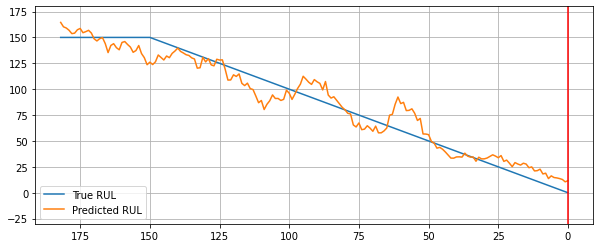

In [41]:
#
# Visualize the RUL prediction for one of the engines
#
engine_id = id_test[1]
inputs = input_tensors(x0, y0, [engine_id])

x = (get_engine(df, engine_id)['time_max'] - get_engine(df, engine_id)['time']).values[-len(inputs[1]):]
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot( x, inputs[1], label='True RUL' )
ax.plot( x, model.predict(inputs[0]), label='Predicted RUL')
ax.grid(True)
ax.legend()
ax.set_ylim(-0.2*MAX_RUL, 1.2*MAX_RUL)
ax.axvline(x=0, color='red')
ax.invert_xaxis()
plt.savefig('3.pdf')